# Ensemble Learning: Stacking.

Stacking is an ensemble learning technique which is used to combine the predictions of diverse classification models into one single model also known as the meta-classifier. This notebook is adapted from [[1](#References)].



All the individual models are trained separately on the complete training data set and fine-tuned to achieve a greater accuracy. The bias and variance trade-off is taken care off for each model. The final model, also known as the meta-classifier is fed either the class labels predicted by the base models or the predicted probabilities for each class label. The meta-classifier is then trained based on the outputs given by the ensemble models. 

The predicted probabilities of each model from stage 1 are fed as an input to all the models at stage 2. The models at stage 2 are then fine-tuned and the corresponding outputs are fed to models at stage 3 and so on. This process occurs multiple times based on how many layers of stacking one would like to use. The final stage consists of one single powerful model, which gives us the final output by combining the output of all the models present in the previous layers. This single powerful model at the end of a stacking pipeline is called the meta-classifier. Often times, using stacking classifiers increases the prediction accuracy of a model. But in no way can there be a guarantee that using stacking will increase the prediction accuracy at all times! Take a look at the below diagrams to understand how stacking works. You can refer to the MLEXTEND GitHub page highlighted in bold to get more ideas on how to implement stacking in different scenarios.  

<tr>
<td> <img src="../images/StackingFINAL.jpg"> </td>
</tr>

In the below code sample, we will use eight different base learners and train each of them on the whole dataset. Each of these models can be fine-tuned using grid search cross-validation. Each of these N models will predict eight class labels. At the final stage, the predictions of all the base models are combined using majority voting (for classification tasks), to create a final model called the meta-classifier. The meta-classifier in our case is the logistic regression model. As we can see from the outputs below, stacking has indeed managed to increase the accuracy of the final model although the increase is very less. But you get the idea! Like the previous examples, we will use a 3 fold cross-validation. Again, you can experiment with this value when you work with some real-world datasets. Further down, in a separate example, we will try grid search cross-validation on the base learners and see if the overall accuracy increases (well, it should actually)

In [1]:
%matplotlib inline
import sqlite3, pandas as pd, numpy as np, nltk, string, matplotlib.pyplot as plt, seaborn as sns
import string, math, pickle
import warnings

warnings.filterwarnings("ignore")

from xgboost.sklearn import XGBModel, XGBRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import datasets
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder

### Load Iris dataset + pair plots

In [2]:
#Load Iris.csv into a pandas dataFrame.
iris_dataset = pd.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
X, y = iris_dataset.iloc[:,0:4], iris_dataset.iloc[:,4]

### Encode categorical variables

In [3]:

encoder_object = LabelEncoder()
y = encoder_object.fit_transform(y)

### Stacking classifiers

In [4]:
RANDOM_SEED = 0


#Base Learners
rf_clf = RandomForestClassifier(n_estimators=10, random_state=RANDOM_SEED)
et_clf = ExtraTreesClassifier(n_estimators=5, random_state=RANDOM_SEED)
knn_clf = KNeighborsClassifier(n_neighbors=2)
svc_clf = SVC(C=10000.0, kernel='rbf', random_state=RANDOM_SEED)
rg_clf = RidgeClassifier(alpha=0.1, random_state=RANDOM_SEED)
lr_clf = LogisticRegression(C=20000, penalty='l2', random_state=RANDOM_SEED)
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=RANDOM_SEED)
adab_clf = AdaBoostClassifier(n_estimators=100)
lr = LogisticRegression(random_state=RANDOM_SEED) # meta classifier

sclf = StackingClassifier(classifiers=[rf_clf, et_clf, knn_clf, svc_clf, rg_clf, lr_clf, dt_clf, adab_clf], meta_classifier=lr)

classifier_array = [rf_clf, et_clf, knn_clf, svc_clf, rg_clf, lr_clf, dt_clf, adab_clf, sclf]
labels = [clf.__class__.__name__ for clf in classifier_array]

acc_list = []
var_list = []

for clf, label in zip(classifier_array, labels):
    cv_scores = model_selection.cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (cv_scores.mean(), cv_scores.std(), label))
    acc_list.append(np.round(cv_scores.mean(),4))
    var_list.append(np.round(cv_scores.std(),4))
    #print("Accuracy: {} (+/- {}) [{}]".format(np.round(scores.mean(),4), np.round(scores.std(),4), label))

Accuracy: 0.9667 (+/- 0.0189) [RandomForestClassifier]
Accuracy: 0.9533 (+/- 0.0094) [ExtraTreesClassifier]
Accuracy: 0.9467 (+/- 0.0094) [KNeighborsClassifier]
Accuracy: 0.9600 (+/- 0.0163) [SVC]
Accuracy: 0.7933 (+/- 0.0340) [RidgeClassifier]
Accuracy: 0.9733 (+/- 0.0189) [LogisticRegression]
Accuracy: 0.9333 (+/- 0.0189) [DecisionTreeClassifier]
Accuracy: 0.9600 (+/- 0.0163) [AdaBoostClassifier]
Accuracy: 0.9600 (+/- 0.0163) [StackingClassifier]


### Visualize performance

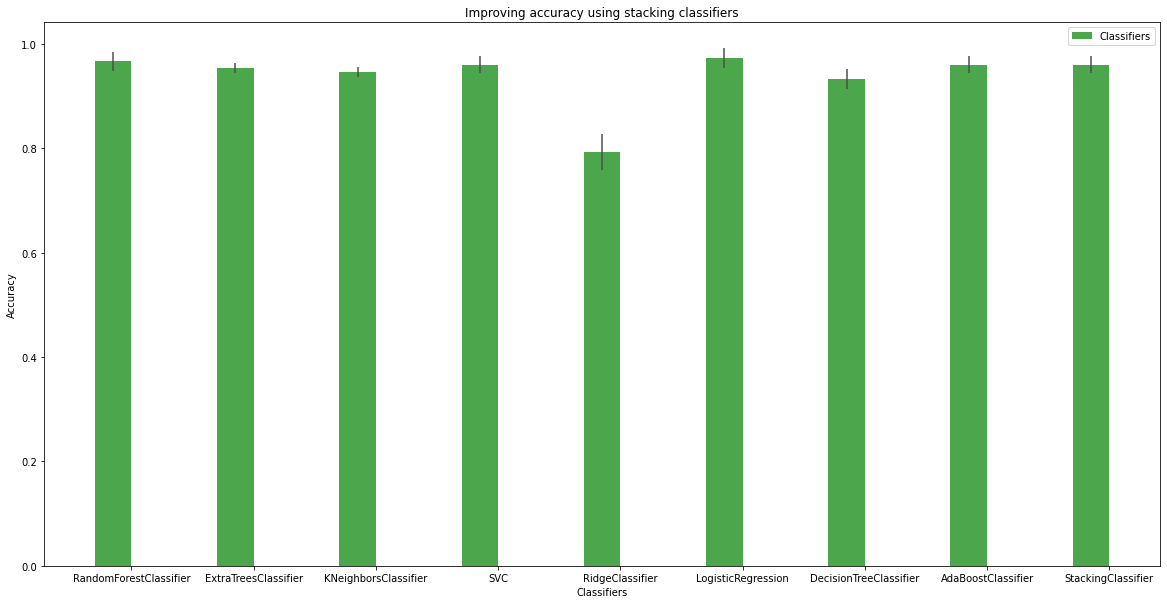

In [5]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
n_groups = 9
index = np.arange(n_groups)
bar_width = 0.30

opacity = .7
error_config = {'ecolor': '0.3'}

normal_clf = ax.bar(index, acc_list, bar_width, alpha=opacity, color='g', yerr=var_list, error_kw=error_config, label='Classifiers')

ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy')
ax.set_title('Improving accuracy using stacking classifiers')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((labels))
ax.legend()
plt.show()

### Visualizing decision boundary

For simplicity, we will look at the decision regions obtained using three of our base learners and also the final stacked meta-classifier. The three base learners that we will select for this purpose are RandomForestClassifier, SupportVectorClassifer, and RidgeClassifier. As like before, I will train and fit the model to two of the most important features, i.e. "petal_length" and "petal_width". 

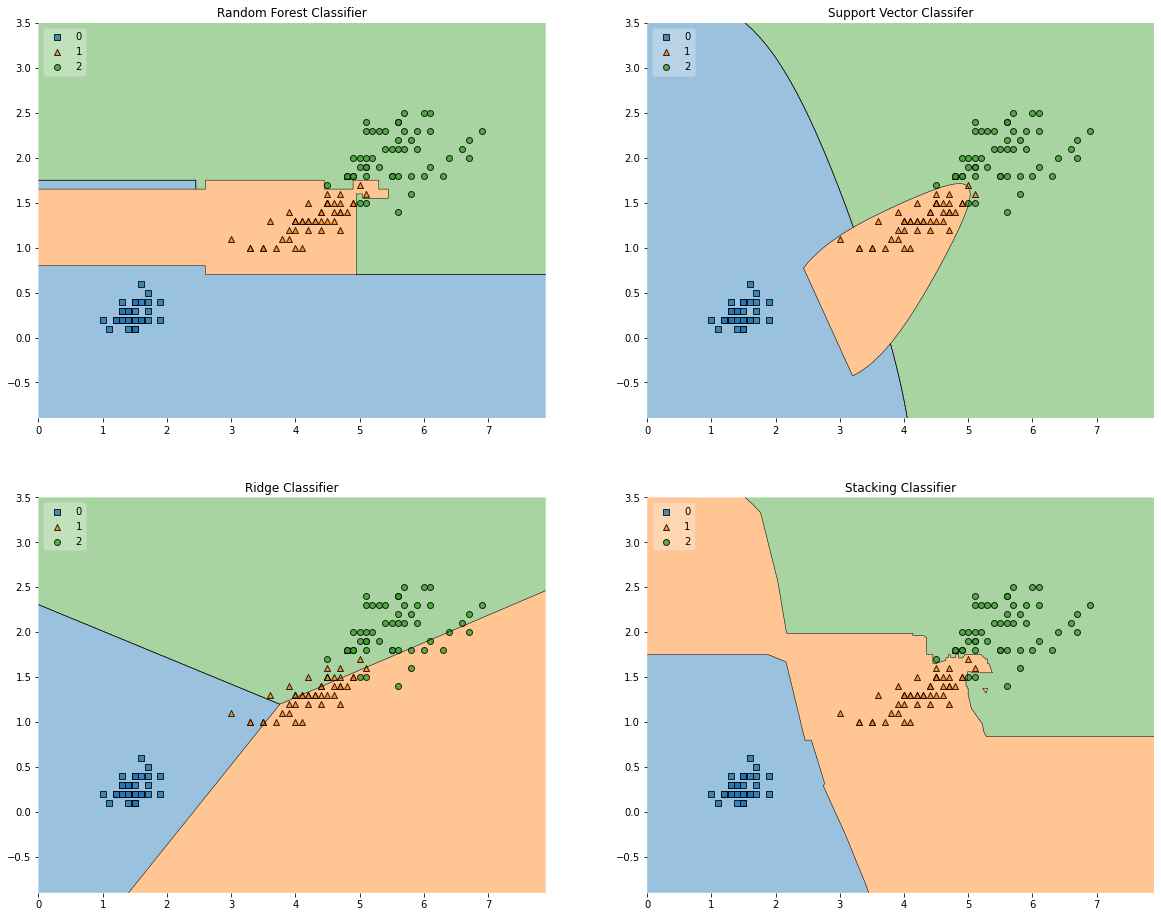

In [6]:
#Decision Regions for 4 algorithms.
X = np.array(iris_dataset[['petal_length','petal_width']])
y = np.array(y)

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(20,16))


for clf, label, grd in zip([rf_clf, svc_clf, rg_clf, sclf], 
                           ["Random Forest Classifier", "Support Vector Classifer", "Ridge Classifier", "Stacking Classifier"], 
                           itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

# References

[1] S. Paual. [Ensemble Learning — Bagging, Boosting, Stacking and Cascading Classifiers in Machine Learning using SKLEARN and MLEXTEND libraries](https://medium.com/@saugata.paul1010/ensemble-learning-bagging-boosting-stacking-and-cascading-classifiers-in-machine-learning-9c66cb271674) 